# Лабораторная работа №2
## Сеников Михаил Олегович ББМО-02-23


In [1]:
variant = 58 % 16 + 1
print(f"Вариант №{variant}")

Вариант №11


11. OpenStack



### Подключение библиотек



In [9]:
# Библиотека для использования регулярных выражений
import re
# Библиотека для работы с классом времени
from datetime import datetime
# Библиотека для использования базы данных SQLite
import sqlite3
# Библиотека для удобной работы с табличными данными
import pandas as pd
# Библиотека для удобной визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dts

### Установка и открытие лог-файла


In [92]:
# Откроем файл и выведем его содержимое (Первые 5 строк)
OpenStack_logs = open('OpenStack_2k.log', 'r').readlines()
for log in OpenStack_logs[:5]:
  print(log.replace('\n', ''))

nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.008 25746 INFO nova.osapi_compute.wsgi.server [req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829
nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.272 25746 INFO nova.osapi_compute.wsgi.server [req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2577181
nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:01.551 25746 INFO nova.osapi_compute.wsgi.server [req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2731631
nova

Отдельная запись выглядит следующим образом:

Структура следующая:
* Logrecord
* Date
* Time
* Pid
* Level
* Component
* ADDR
* Content

### Парсинг лог-файла

In [93]:
openstack_logs_normalized = []
for log in OpenStack_logs:

    log_str = log.split()
    Logrecord = log_str[0]
    Date = log_str[1]
    Time = log_str[2]
    Pid = log_str[3]
    Level = log_str[4]
    curr_id = 5
    Component = ""
    ip_reg = "(?<![\.\d])(?:[0-9]\.|1\d?\d?\.|2[0-5]?[0-5]?\.){3}(?:[0-9]|1\d?\d?|2[0-5]?[0-5]?)(?![\.\d])" #"^\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}"
    find_ip = False
    for el in log_str[6:]:        
        if re.match(ip_reg, el):
            find_ip = True
            break
        Component = Component + " " + el
        curr_id = curr_id + 1
    
    if(not find_ip):
        continue
    ADDR = log_str[curr_id+1]
    Content = ' '.join(log_str[curr_id+2:]).replace("\"", "")
    openstack_logs_normalized.append([Logrecord, Date, Time, Pid, Level, Component, ADDR, Content])

for el in openstack_logs_normalized[10:20]:
  print(el)

['nova-api.log.1.2017-05-16_13:53:08', '2017-05-16', '00:00:07.864', '25746', 'INFO', ' [req-546e2e6a-b85e-434a-91dc-53a0a9124a4f 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -]', '10.11.10.1', 'GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1 status: 200 len: 1893 time: 0.2733629']
['nova-api.log.1.2017-05-16_13:53:08', '2017-05-16', '00:00:08.137', '25746', 'INFO', ' [req-e2c35e53-06d3-4feb-84b9-705c94d40e5b 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -]', '10.11.10.1', 'GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1 status: 200 len: 1893 time: 0.2694771']
['nova-api.log.1.2017-05-16_13:53:08', '2017-05-16', '00:00:09.411', '25746', 'INFO', ' [req-ce9c8a59-c9ba-43b1-9735-318ceabc9216 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -]', '10.11.10.1', 'GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1 status: 200 len: 1893 time: 0.2692339']
['nova-api.log.1.2017-05-

### Сохранение каждой записи в СУБД

In [94]:
# Создание СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, Logrecord, Date, Time, Pid, Level, Component, Addr, Content)")

# Внесение данных в СУБД
for el in openstack_logs_normalized:
    query = f'INSERT INTO logs (Logrecord, Date, Time, Pid, Level, Component, Addr, Content) VALUES ("{el[0]}", "{el[1]}", "{el[2]}", "{el[3]}", "{el[4]}", "{el[5]}", "{el[6]}", "{el[7]}")'
    try:
        cursor.execute(query)
    except:
        print(query)

# Закрытие СУБД
connection.commit()
cursor.close()
connection.close()

# Открытие СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
data = cursor.fetchall()
cursor.close()
connection.close()
pd_data = pd.DataFrame(data, columns=("i", "Logrecord", "Date", "Time", "Pid", "Level", "Component", "ADDR", "Content"))
pd_data

,i,Logrecord,Date,Time,Pid,Level,Component,ADDR,Content
0,1,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.008,25746,INFO,[req-38101a0b-2096-447d-96ea-a692162415ae 113...,10.11.10.1,GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/serve...
1,2,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:00.272,25746,INFO,[req-9bc36dd9-91c5-4314-898a-47625eb93b09 113...,10.11.10.1,GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/serve...
2,3,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.551,25746,INFO,[req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113...,10.11.10.1,GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/serve...
3,4,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:01.813,25746,INFO,[req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113...,10.11.10.1,GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/serve...
4,5,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:00:03.091,25746,INFO,[req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113...,10.11.10.1,GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/serve...
...,...,...,...,...,...,...,...,...,...
1012,1013,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.199,25793,INFO,[req-667e1983-f313-4cac-9f50-5203fb4ac0be - -...,"10.11.21.143,10.11.10.1",GET /latest/meta-data/block-device-mapping/ami...
1013,1014,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.215,25795,INFO,[-],"10.11.21.143,10.11.10.1",GET /latest/meta-data/block-device-mapping/roo...
1014,1015,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.410,25746,INFO,[req-699eeadf-6db8-44a4-8521-1ab4e8a53b53 113...,10.11.10.1,DELETE /v2/54fadb412c4e40cdbaed9335e4c35a9e/se...
1015,1016,nova-api.log.1.2017-05-16_13:53:08,2017-05-16,00:14:47.652,25799,INFO,[req-e5e061d6-f2aa-464b-9512-2fd6c7c9a812 - -...,"10.11.21.143,10.11.10.1",GET /latest/meta-data/placement/ HTTP/1.1 stat...


### Визуализация результатов

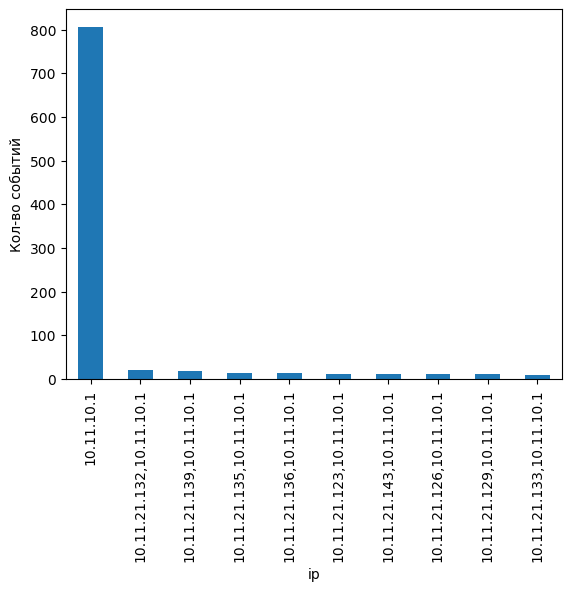

In [95]:
pd_data_distrib = pd_data['ADDR'].value_counts()[:10]
pd_data_distrib.plot(kind='bar')

plt.xlabel('ip')
plt.ylabel('Кол-во событий')
plt.show()